In [3]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# German Credit

Example using weight of Evidence binning on 'German Credit dataset', as well as creating feature importance plots

first run:
    
    bash weight_of_evidence/get_dataset.sh

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
import pandas as pd
import numpy as np

In [62]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, roc_auc_score

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from weight_of_evidence import weight_of_evidence

In [9]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence.weight_of_evidence' from '/Users/olivercairns/Desktop/code/personal/WeightOfEvidenceDemo/weight_of_evidence/weight_of_evidence.py'>

In [11]:
DATA_PATH = "weight_of_evidence/data/german_credit_data.csv"

COLUMN_NAMES = [
    "chk_acct",
    "duration",
    "credit_his",
    "purpose",
    "amount",
    "saving_acct",
    "present_emp",
    "installment_rate",
    "sex",
    "other_debtor",
    "present_resid",
    "property",
    "age",
    "other_install",
    "housing",
    "n_credits",
    "job",
    "n_people",
    "telephone",
    "foreign",
    "response",
]

data = pd.read_csv(DATA_PATH, sep=" ", names=COLUMN_NAMES)

data["response"] = data["response"] - 1

EXCLUDE_COLS = [
    "response",
]

In [12]:
CATERORICAL_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("O").columns

In [13]:
NUMERIC_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("int64").columns

In [14]:
data[CATERORICAL_COLS] = data[CATERORICAL_COLS].fillna("MISSING")

In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [45]:
X = data.drop(columns=EXCLUDE_COLS)
y = data.response

In [46]:
def get_cv_results(X, y, cv, clf, model_name):
    results = {"auc": [], "fold": []}
    fold = 1
    for train, test in cv.split(X, y):
        print(f"fold {fold}")
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        try:
            auc = roc_auc_score(y_true=y.iloc[test], y_score=prediction[:, 1])
        except:
            from IPython import embed

            embed()
        results["auc"].append(auc)
        results["fold"].append(fold)
        print(f"auc {auc}")
        fold += 1
    results_df = pd.DataFrame(results)
    results_df["model"] = model_name
    return results_df

In [47]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner()),
        ("woe_scale", weight_of_evidence.LogitScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", log_reg),
    ]
)

In [48]:
get_cv_results(X, y, cv, woebin_logit, "woe binned logit")

fold 1
auc 0.7275
fold 2
auc 0.8042857142857143
fold 3
auc 0.7934523809523809
fold 4
auc 0.7301190476190477
fold 5
auc 0.8164285714285714


,auc,fold,model
0,0.727500,1,woe binned logit
1,0.804286,2,woe binned logit
2,0.793452,3,woe binned logit
3,0.730119,4,woe binned logit
4,0.816429,5,woe binned logit


In [49]:
woebin_logit.fit(X, y)

Pipeline(steps=[('tree_bin', TreeBinner()), ('woe_scale', LogitScaler()),
                ('standard_scale', StandardScaler()),
                ('log_reg_classifier', LogisticRegression(max_iter=1000000.0))])

In [50]:
def plot_feature_importance(
    var_names, coefficients, n=10, output_dir=None, verbose=True
):
    """
    Find logit regression feature importance
    Args:
        var_names (series): variable names
        coefficients (series): regression coefficients
        n (integer): how many features to plot
    """
    coef_df = pd.DataFrame()
    coef_df["var_names"] = var_names
    coef_df["coef_vals"] = coefficients
    coef_df["abs_vals"] = np.abs(coef_df.coef_vals)
    coef_df = coef_df.set_index("var_names").sort_values(by="abs_vals", ascending=True)
    if verbose:
        plt.figure(figsize=(4, 8))
        ax = coef_df.tail(n).coef_vals.plot.barh()
        plt.title(f"Top {n} features - logistic regression \n")
        plt.show()
    return coef_df.reset_index()

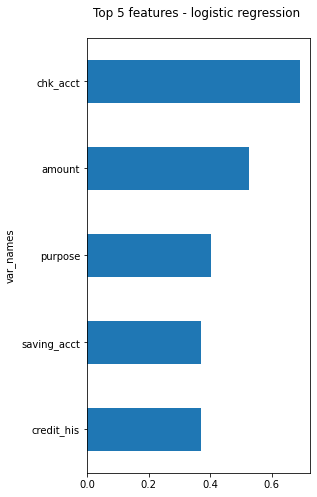

In [51]:
var_importance = plot_feature_importance(
    X.columns, woebin_logit["log_reg_classifier"].coef_[0], n=5
)

In [52]:
top_5 = var_importance.tail(5).var_names[::-1]

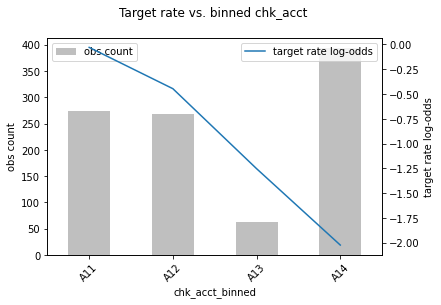

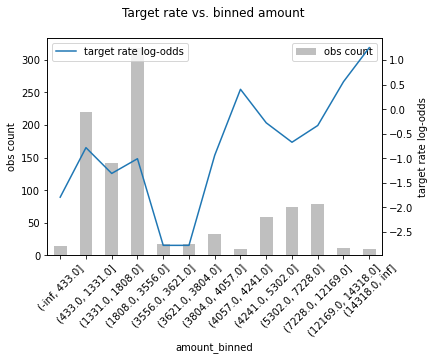

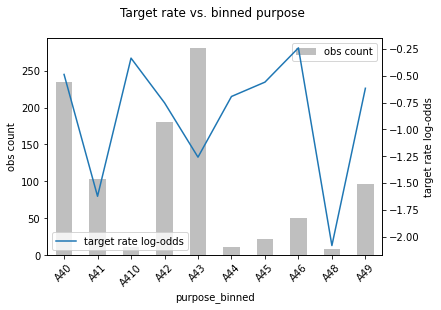

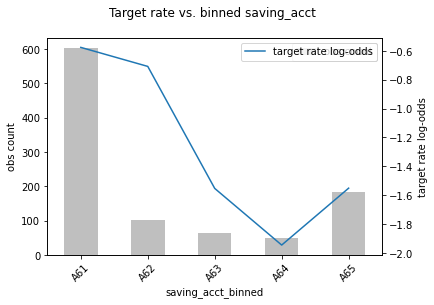

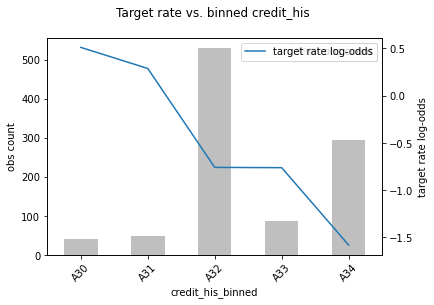

In [53]:
weight_of_evidence.plot_bins(
    X[top_5], y, woebin_logit["tree_bin"].splits_, space="log-odds"
)

In [54]:
first = X.head(1)

In [55]:
first.T

,0
chk_acct,A11
duration,6
credit_his,A34
purpose,A43
amount,1169
saving_acct,A65
present_emp,A75
installment_rate,4
sex,A93
other_debtor,A101


In [56]:
first_encoded = woebin_logit["standard_scale"].transform(
    woebin_logit["woe_scale"].transform(woebin_logit["tree_bin"].transform(first))
)

In [57]:
first_encoded

array([[ 1.12011276, -2.37955615, -1.25359048, -0.87466321,  0.21058623,
        -1.38577886, -0.74839043,  1.01301495, -0.75214917,  0.03217713,
         0.0526494 , -1.30706043, -1.6043865 , -0.47792823, -0.63320701,
         0.15652927, -0.22835371,  1.        , -1.21459768,  0.19601428]])

In [58]:
woebin_logit["log_reg_classifier"].predict_proba(first_encoded)

array([[0.96401414, 0.03598586]])

In [59]:
y.mean()

0.3

In [60]:
first_importance = first_encoded * woebin_logit["log_reg_classifier"].coef_

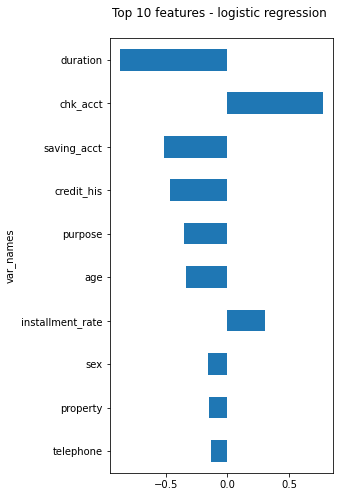

In [61]:
importance_cols = plot_feature_importance(X.columns, first_importance[0], n=10)